<a href="https://colab.research.google.com/github/tiasondjaja/circular_societies/blob/master/examples-Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circular Societies Visualization Tool

In this document, we define:
+ The `Set` class (to create approval sets)
+ The `CircularSociety` class (to create a circular society, which is made up of approval sets)
    + Along with methods for visualizing the circular societies, computing piercing number and approval number, checking (k, m)-agreeability, and transforming the society into Hardin's uniform society.
+ Functions to randomly generate circular societies.

A complete "documentation" and a couple of examples are included below (scroll down).


### How to run and use this document
+ First, run the code cell in the "Setup" section below.  Do not modify anything.
+ Then, optionally, read the documentation and run the code cells in the "Example" section
+ Experiment with your own circular societies

## Setup

Run the code cell in the "Setup" section below once each time the notebook is started. Do not modify anything.

In [ ]:
import numpy as np
import scipy as sp
import cvxpy as cp
import matplotlib.pyplot as plt
import itertools

# Part 0 ----------------------------------
# Define the Set class (approval set)
class Set:
    # Initialize Class
    def __init__( self, name, left_endpt, right_endpt, modulo ):
        self.name = name
        self.left_endpt = left_endpt
        self.right_endpt = right_endpt
        self.modulo = modulo
    
    # Method to print set name and left- and right-endpoints
    def printSetInfo( self ):
        if self.left_endpt <= self.right_endpt:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.right_endpt) + "]")
        elif self.right_endpt == 0:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
        else:
            print( " " + self.name + ": [0," + str(self.right_endpt) + "] U [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
    
    def editSet( self, newname, newleft_endpt, newright_endpt, newmodulo ):
        self.name = newname
        self.left_endpt = newleft_endpt
        self.right_endpt = newright_endpt
        self.modulo = newmodulo
        
    def isPointInSet( self, point):
        check = False
        
        if (self.left_endpt <= point and point <= self.right_endpt):
             check = True
        elif (self.left_endpt <= point and self.right_endpt <= self.left_endpt):
             check = True
        elif (point <= self.right_endpt and self.right_endpt <= self.left_endpt):
             check = True
            
        return check
  
# Part 1 - MAIN ----------------------------------  

# Define the CircularSociety class

class CircularSociety:
    
    # Initialize Class
    def __init__( self, name, modulo, isUniform = 0, tick = 0.5 ):
        self.name = name
        self.modulo = modulo # modulo > 0; the circular society is represented as [0, modulo) with 0 = modulo
        self.approvalSets = [] # initialize with empty approval sets
        self.numVoters = 0
        self.tick = tick
        
        # List of all endpoints and setnames (useful when checking for left-right alternation)
        self.list_setnames = []
        self.list_left_endpts = []
        self.list_right_endpts = []
    
    # method that returns a set given its name
    def getSet( self, setname ):
      for A in self.approvalSets:
        if A.name == setname:
          return A
      return None
    
    ### DISPLAYING / OBTAINING BASIC INFORMATION ABOUT THE CIRCULAR SOCIETY----
    
    # Method to print list of approval sets
    def listApprovalSets( self ):
        for A in self.approvalSets:
            A.printSetInfo()
            
    # Method to print society information
    def printSocietyInfo( self ):
        print("Circular Society Name: " + self.name)
        print("Spectrum: [0, " + str(self.modulo) + "].  (Note: we identify 0 = " + str(self.modulo) + ")"  )
        print("Number of Voters: " + str(self.numVoters) )
        print("Approval Sets:")
        self.listApprovalSets()
    
    # Method to list the endpoints of the sets, from 0 to N
    def listSetEndpoints( self ):
        N = self.numVoters
        orderedendpts = []
        orderednames = []
        setindices_ordered_left = np.argsort(self.list_left_endpts)
        setindices_ordered_right = np.argsort(self.list_right_endpts)
        left_i = 0
        right_i = 0
        
        for step in range( 0, 2*N ):
            if left_i < N and right_i < N:
                if self.list_left_endpts[ setindices_ordered_left[left_i] ] < self.list_right_endpts[ setindices_ordered_right[right_i] ]:
                    orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                    orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                    left_i += 1
                else:
                    orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                    orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                    right_i += 1
            elif left_i == N and right_i < N:
                orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                right_i += 1
            else:
                orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                left_i += 1
        return orderednames, orderedendpts
      
    
    ### FINDING, EDITING, ADDING, REMOVING APPROVAL SETS-----------------------
    
    # Method to find an approval set by name
    def findApprovalSetName( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                return ind # if set name found, return index
        return -1 # if set name not found, return -1 
    
    # Method to add a new approval set into the society
    def addApprovalSet( self, setName, left_endpt, right_endpt ):
        # Check that setName is different from names of sets already on the list
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        if ind == -1:
            newSet = Set( setName, left_endpt, right_endpt, self.modulo )
            
            # Update attributes
            self.approvalSets.append( newSet )
            self.numVoters += 1
            
            # Update list of all endpoints
            self.list_setnames.append( setName )
            self.list_left_endpts.append( left_endpt )
            self.list_right_endpts.append( right_endpt )
            
        else:
            print("Set is not added because this set name has already been chosen.  Please pick a different set name.")

    # Method to remove an approval set from the society
    def removeApprovalSet( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                self.approvalSets.pop(ind)
                self.list_setnames.pop(ind)
                self.list_left_endpts.pop(ind)
                self.list_right_endpts.pop(ind)
                self.numVoters -= 1
    
    # Method to edit the endpoints of an approval set
    def editApprovalSet( self, setName, newleft_endpt, newright_endpt ):
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        
        if ind == -1:
            print("Set name is not found")
        else:
            A = self.approvalSets[ind]
            A.editSet( setName, newleft_endpt, newright_endpt, self.modulo )
            self.list_left_endpts[ind] = newleft_endpt
            self.list_right_endpts[ind] = newright_endpt
    
    
    ### AGREEABILITY, AGREEMENT NUMBER, PIERCING NUMBER -----------------------
    
    # Method to check (k, m) agreeability (brute force)
    def checkAgreeability( self, k, m):
      setNames = [ A.name for A in self.approvalSets ]
      subcollections_m = [list(i) for i in itertools.combinations(setNames, m)]
      good = [] # is the society k,m agreeable? will store 1 or 0 for each collection of m sets
      bad_m_sets = []
      for collection in subcollections_m:
        good_m_sets = [] # will store 1 or 0 for each collection of k sets
        subcollections_k = [list(i) for i in itertools.combinations(collection, k)]
        for collection1 in subcollections_k:
          setname = collection1[0]
          A = self.getSet(setname)
          left = A.left_endpt
          left_list = np.array([self.getSet(setname1).isPointInSet(left) for setname1 in collection1 ])
          left_good = np.prod(left_list)
          right = A.right_endpt
          right_list = np.array([self.getSet(setname1).isPointInSet(right) for setname1 in collection1 ])
          right_good = np.prod(right_list)
          set_good = 1 - ( (1-left_good) * (1-right_good) ) # good if at least one is good
          good_m_sets.append(set_good)
        good_m_sets = np.array(good_m_sets)
        good_m = 1 - np.prod(1-good_m_sets) # good if at least one is good
        if good_m == 0:
          bad_m_sets.append(collection)
        good.append(good_m)
      good = np.array(good)
      is_kmagreeable = np.prod(good) # good if all is good
      return is_kmagreeable, bad_m_sets
    
    # Method to the find agreement number (and the location)
    def findAgreementNumber( self ):
        Names, Endpts = self.listSetEndpoints()
        agreement = 0
        agrement_location = Endpts[0]
        
        # At each point, the number of intersecting sets changes only when an endpoint is encountered,
        #  therefore, we will check the number of intersecting sets only at endpoints
        for i in Endpts:
          numSets_contain_i = 0
          
          for A in self.approvalSets:
            if A.isPointInSet( i ):
              numSets_contain_i = numSets_contain_i + 1
          
          if numSets_contain_i > agreement:
            agreement = numSets_contain_i
            agreement_location = i
          
        return agreement, agreement_location
      
    def findPiercingNumber( self ):
      # Finding piercing number using an integer linear program (ILP) formulation
      # (a linear program (LP) that is constrained to have integer solutions)
      
      # First, find constraint matrix/data for LP used to find piercing number
      # Candidate piercing points are the endpoints of the intervals
      _, orderedendpts = self.listSetEndpoints()
      N = self.numVoters
      M = 2*N
      Mat = np.empty( [ N, M] )
      for i in np.arange(0, N):
        for j, p in enumerate(orderedendpts):
          A = self.approvalSets[i]
          Mat[i, j] = A.isPointInSet( p )
      
      # Next, vector of coefficients of objective function
      c = np.ones(M)
      
      ## Solve ILP using cvxpy
      x = cp.Variable(M, integer = True)
      objective = cp.Minimize( cp.matmul(c, x) )
      constraints = [ cp.matmul(Mat,x) >= np.ones(N), 0 <= x, x <= 1]
      prob = cp.Problem( objective, constraints )
      val = prob.solve(solver='GLPK_MI')
      piercingNumber = int(np.round(val))
      piercingSet = np.transpose(orderedendpts)[ np.round(x.value) > 0]
      
      return piercingNumber, piercingSet, x.value, Mat
    
    # implementing the linear society piercing number algorithm
    def piercingAlgorithm( self, startingPoint = 0 ):

      orderedendptnames, orderedendpts = self.listSetEndpoints()

      if startingPoint > 0 :
        temp1 = [ x for x in orderedendpts if x >= startingPoint ]
        temp1names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] >= startingPoint]
        temp2 = [x for x in orderedendpts if x < startingPoint]
        temp2names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] < startingPoint]
        orderedendpts = temp1 + temp2
        orderedendptnames = temp1names + temp2names

      uncovered_setnames = []
      N = self.numVoters
      for i in range(0, 2*N):
        if( orderedendptnames[i][0] == "R" ):
          uncovered_setnames.append( orderedendptnames[i][1:] )

      # currently, uncovered_setnames contains all sets' names
      piercingSet = []
      while( len(uncovered_setnames) > 0): #while there are uncovered sets
        current_point = self.getSet(uncovered_setnames[0]).right_endpt
        covered_setnames = [setname for setname in uncovered_setnames if self.getSet(setname).isPointInSet(current_point) ]
        uncovered_setnames = [setname for setname in uncovered_setnames if not self.getSet(setname).isPointInSet(current_point) ]
        piercingSet.append( [current_point, covered_setnames] )
      return piercingSet


    ### HARDIN'S TRANSFORMATIONS (ELIMINATE CONTAINMENT, LR-ALTERNATION)-------
    
    # Method to check if Left-Right-alternating
    def is_LR_alt( self, findRRL = False ):
        L = self.listSetEndpoints()
        numEndpts = len(L[0])
        
        # determine if LR alternating; if findRRL is True, also find names of sets where of RRL endpoints occur
        isLR = True
        RRLsets = list()
        for i in range(0, numEndpts):
            # determine if LR alternating
            if L[0][i][0] == L[0][(i+1)%numEndpts][0]:
                isLR = False
            # find names of sets where of RRL endpoints occur
            if ( findRRL ):
                if(L[0][i%numEndpts][0] == "R" and L[0][(i+1)%numEndpts][0] == "R" and L[0][(i+2)%numEndpts][0] == "L"):
                    RRLsets.append( [ L[0][i%numEndpts][1:], L[0][(i+1)%numEndpts][1:], L[0][(i+2)%numEndpts][1:] ])
        
        if findRRL:
          return isLR, RRLsets
        else:
          return isLR
        
    # Method to check if a pair of sets has containment 
    def checkContainmentPair( self, setPair ):
      Set1Name = setPair[0]
      Set2Name = setPair[1]
      indSet1 = self.findApprovalSetName( Set1Name )
      indSet2 = self.findApprovalSetName( Set2Name )
      containmentIsFound = False
      
      if (indSet1 == -1 or indSet2 == -1):
        print("At least one of the set names is not found")
      else:
        A1 = self.approvalSets[indSet1]
        A2 = self.approvalSets[indSet2]
        
        if( A1.left_endpt <= A1.right_endpt and A2.left_endpt <= A2.right_endpt): 
          # Case 1: A1, A2 both don't wrap around
          if( A1.left_endpt <= A2.left_endpt and A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A2.left_endpt <= A1.left_endpt and A1.right_endpt <= A2.right_endpt ):
            containmentIsFound = True # A1 is contained in A2
          
        elif ( A1.left_endpt <= A1.right_endpt and A2.left_endpt > A2.right_endpt ): 
          # Case 2: A1 doesn't wrap, A2 wraps around
          if( A1.right_endpt <= A2.right_endpt or A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True #A1 is contained in A2
            
        elif ( A1.left_endpt > A1.right_endpt and A2.left_endpt <= A2.right_endpt ): 
          # Case 3: A1 wraps, A2 doesn't wrap around
          if( A1.left_endpt <= A2.left_endpt or A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True #A2 is contained in A1
          
        else: 
          # Case 4: A1, A2 both wrap around
          if( A2.right_endpt <= A1.right_endpt and A1.left_endpt <= A2.left_endpt):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A1.right_endpt <= A2.right_endpt and A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True # A1 is contained in A2
            
      return containmentIsFound
    
    # Method to detect any containent and identifying pairs
    def checkContainmentAll( self, findContainmentPairs = False ):
      N = self.numVoters
      approvalSetNames = self.list_setnames
      containmentPairs = []
      containmentIsFound = False
      
      for i in np.arange(0, N):
        setName1 = self.list_setnames[i]
        for j in np.arange(i+1, N):
          setName2 = self.list_setnames[j]
          
          if ( self.checkContainmentPair( [setName1, setName2]) ):
            
            containmentPairs.append( [setName1, setName2] )
            containmentIsFound = True
            
      if findContainmentPairs:
        return containmentIsFound, containmentPairs
      else:
        return containmentIsFound
    
    # Method to eliminate a pair of containment
    def eliminateContainmentPair( self, containmentPair ):
        smallSetName = containmentPair[0]
        largeSetName = containmentPair[1]
        indSmallSet = self.findApprovalSetName( smallSetName )
        indLargeSet = self.findApprovalSetName( largeSetName )
        
        if (indSmallSet == -1 or indLargeSet == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpoints of the two sets
            ASmall = self.approvalSets[indSmallSet]
            ALarge = self.approvalSets[indLargeSet]
            
            small_right_endpt = ASmall.right_endpt
            small_newright_endpt = ALarge.right_endpt
            large_newright_endpt = small_right_endpt
            
            self.editApprovalSet( smallSetName, ASmall.left_endpt, small_newright_endpt )
            self.editApprovalSet( largeSetName, ALarge.left_endpt, large_newright_endpt )

    # Method to eliminate all containments
    def eliminateContainmentAll( self ):
      
      containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True)
      maxIt = 100
      it = 0
      
      while(containmentIsFound and it < maxIt):
        for setPair in containmentPairs:
          self.eliminateContainmentPair( setPair )
        containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True )
        it = it + 1
      
            
    # Method to eliminate a set of RRL endpoints
    def eliminateRRLTriple( self, RRLsets ):
        Set2Name = RRLsets[1] # first set is unchanged
        Set3Name = RRLsets[2]
        indSet2 = self.findApprovalSetName( Set2Name )
        indSet3 = self.findApprovalSetName( Set3Name )
        
        if (indSet2 == -1 or indSet3 == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpt of Set2 and the left endpoint of Set3
            A2 = self.approvalSets[indSet2]
            A3 = self.approvalSets[indSet3]
            
            set2_right_endpt = A2.right_endpt
            set2_newright_endpt = A3.left_endpt
            set3_newleft_endpt = set2_right_endpt
            
            self.editApprovalSet( Set2Name, A2.left_endpt, set2_newright_endpt)
            self.editApprovalSet( Set3Name, set3_newleft_endpt, A3.right_endpt )
    
    # Method to eliminate all RRL (to achieve LR-alternation)
    def eliminateRRLAll( self, maxIt = 10000 ):
        isLR, RRLsets = self.is_LR_alt( findRRL = True )
        
        numIt = 0
        while( not isLR and numIt < maxIt):
          for triple in RRLsets:
            self.eliminateRRLTriple( triple )
          isLR, RRLsets = self.is_LR_alt( findRRL = True )
          numIt = numIt + 1
        
        if ( not isLR ):
          print("Max iteration reached but the society is still not LR-Alternating")

    # Method to transform into a uniform society
    def uniformize( self ):
        self.eliminateContainmentAll()
        self.eliminateRRLAll()
        

        
    ### VISUALIZATION --------------------------------------------------------
    
    # Method to visualize the sets
    def visualize( self, drawAgreement = False, drawPiercing = False ):
        
        ## Set up grid
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        # Major ticks every 1, minor ticks every self.tick (default = 0.5)
        major_ticks = np.arange(0, self.modulo+1, self.modulo * 0.1)
        minor_ticks = np.arange(0, self.modulo+1, self.tick)        
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        #ax.set_yticks(major_ticks)
        #ax.set_yticks(minor_ticks, minor=True)
        # Different thickness settings for the major and minor grids:
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        plt.yticks(np.arange(0, self.numVoters+1, step = 1) )
        
        # Draw the intervals
        for ind, A in enumerate( self.approvalSets ):
            if A.left_endpt <= A.right_endpt:
                x = [A.left_endpt, A.right_endpt]
                y = [ind+1, ind+1]
                plt.plot( x, y, 'ro-')
            else:
                x = [A.left_endpt, self.modulo]
                y = [ind+1, ind+1]
                plt.plot( A.left_endpt, ind+1, 'ro-', self.modulo, ind+1, 'r>-')
                plt.plot( x, y, 'r')
                x = [0, A.right_endpt]
                plt.plot( 0, ind+1, 'r<-', A.right_endpt, ind+1, 'ro-')
                plt.plot( x, y, 'r')
                
        # Draw one of the points that attains agreement number
        if drawAgreement:
            a, pos = self.findAgreementNumber()
            plt.plot( [pos, pos], [0.8, self.numVoters], 'blue' )
        
        # Draw the piercing points
        if drawPiercing:
          piercingNum, piercingSet, _, _ = self.findPiercingNumber()
          for pos in piercingSet:
            plt.plot( [pos, pos], [0, 0.2 + self.numVoters], 'green', linestyle = 'dashed' )

# Part 3 - generating random circular societies ----------------------------------    

# Define function to generate a random fixed-length circular society
def generateRandomFixedLengthSociety( societyname, N, modulo, p, tick = 0.5 ):
    # N is number of voters
    # modulo is the circumference of the circular society
    # p is a fraction between 0 and 1 that controls the length of approval sets
    #    The length of each set is p times modulo
    # tick = 0.5 : controls tick marks in the visualization
    
    CS = CircularSociety( societyname, modulo, tick = tick )
    
    for i in list(range(N)):
      left = np.random.uniform(low=0, high=modulo)
      right = (left + p * modulo) % modulo
      CS.addApprovalSet( "Set " + str(i+1), left , right )
    
    return CS

# extras:
# Define function to generate a circular society with a random approval sets
def generateRandomSociety( societyname, N, modulo, epsilon = 0.5, mode = 1, a = 1, b = 1 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    # N is number of voters
    # mode lets us choose how the approval sets are generated
    #   mode = 1: endpoints are chosen uniformly at random from [0, modulo]
    #   mode = 2: left endpoint is chosen uniformly at random from [0, modulo]; 
    #             set length is from the beta distribution with parameters a, b
    
    CS = CircularSociety( societyname, modulo, tick = epsilon )
    
    for i in list(range(N)):
      if mode == 1:
        left = np.random.uniform(low=0, high=modulo)
        right = np.random.uniform(low=0, high=modulo)
      elif mode == 2:
        left = np.random.uniform(low=0, high=modulo) 
        right = (left + np.random.beta(a, b)* modulo) % modulo
        
      CS.addApprovalSet( "Set " + str(i+1), left , right )
    
    
    return CS
  
# Define function to generate U(N, h) (Hardin's uniform circular society)
def generateUniformCircularSociety( societyname, N, h, epsilon = 0.5 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    
    CS = CircularSociety( societyname, N, tick = epsilon )
    
    for i in list(range(N)):
        CS.addApprovalSet( "Set " + str(i+1), i, round( (i + h - epsilon) % N, 1) )
    return CS

## Documentation

https://github.com/tiasondjaja/circular_societies/blob/master/DOCUMENTATION.md

## Examples

### Example 1

Circular Society Name: S1
Spectrum: [0, 10].  (Note: we identify 0 = 10)
Number of Voters: 5
Approval Sets:
 Set1: [3, 5]
 Set2: [0,3] U [6, 10]
 Set3: [5, 8]
 Set4: [0,1] U [7, 10]
 Set5: [6, 9]
4
7


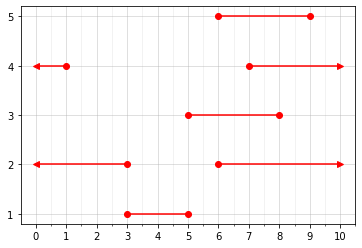

In [ ]:
# Example 1  (Run this cell by pressing Shift + Enter or clicking the "play" button on the left)

# Creating a circular society named A (with a string name "S1") where the spectrum is [0, 10] (where 0 = 10)
A = CircularSociety( "S1", 10)

#   Adding sets 
A.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
A.addApprovalSet( "Set2", 0, 2 )
A.addApprovalSet( "Set3", 5, 8 )
A.addApprovalSet( "Set4", 7, 1 )
A.addApprovalSet( "Set5", 6, 9 )
A.addApprovalSet( "Set6", 2, 4 )

#  Editing an existing set
A.editApprovalSet( "Set2", 6, 3)

#  Removing a set (by its names)
A.removeApprovalSet( "Set6" )

#  Displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
A.printSocietyInfo()

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
A.visualize( )

#  Checking if the set is left-right alternating (returns True or False)
A.is_LR_alt()

# Finding the agreement number of the society
a, pos = A.findAgreementNumber()
print(a)
print(pos)

### Example 2

Circular Society Name: Soc1
Spectrum: [0, 7].  (Note: we identify 0 = 7)
Number of Voters: 7
Approval Sets:
 Set 1: [0, 3.5]
 Set 2: [1, 4.5]
 Set 3: [2, 5.5]
 Set 4: [3, 6.5]
 Set 5: [0,0.5] U [4, 7]
 Set 6: [0,1.5] U [5, 7]
 Set 7: [0,2.5] U [6, 7]
(['LSet 1', 'RSet 5', 'LSet 2', 'RSet 6', 'LSet 3', 'RSet 7', 'LSet 4', 'RSet 1', 'LSet 5', 'RSet 2', 'LSet 6', 'RSet 3', 'LSet 7', 'RSet 4'], [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5])
Is the society left-right alternating? True
Agreement number is:  4
Location of max agreement along the horizontal axis (potentially one of several):  0


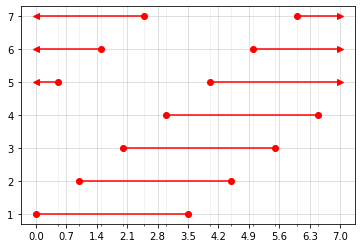

In [ ]:
# Example 2 (Run this cell by pressing Shift + Enter or clicking the "play" button to the side)

# Generating a Uniform Society named S1 (with a string name "Soc1"), U(7, 4)
S1 = generateUniformCircularSociety( "Soc1", 7, 4)

#  Displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
S1.printSocietyInfo()

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S1.visualize( )

# Displaying the list of left/right endpoints starting from x = 0.
print(S1.listSetEndpoints())

# Checking if the set is left-right alternating (returns True or False)
print("Is the society left-right alternating?", S1.is_LR_alt() )

# Find the agreement number of this society
a, location = S1.findAgreementNumber()
print("Agreement number is: ", a)
print("Location of max agreement along the horizontal axis (potentially one of several): ", location)

### Example 3a: Randomly-generated circular societies

Circular Society Name: A
Spectrum: [0, 10].  (Note: we identify 0 = 10)
Number of Voters: 10
Approval Sets:
 Set 1: [0,6.897229184546641] U [7.6851364992776805, 10]
 Set 2: [4.599096259321124, 7.702448577256988]
 Set 3: [0,2.4823822351373703] U [5.656537765844022, 10]
 Set 4: [4.307460808038254, 5.715783199724714]
 Set 5: [2.5212578319380388, 2.736452258747417]
 Set 6: [0.6360914993865119, 9.521166419655941]
 Set 7: [3.4301433690826153, 4.525416748179966]
 Set 8: [0,0.6668826166361819] U [3.6913482412050023, 10]
 Set 9: [0,8.039160821268931] U [9.022900679328655, 10]
 Set 10: [0,1.2561703443771322] U [3.5695255842926255, 10]
Agreement number is:  8
Location of max agreement along the horizontal axis (potentially one of several):  5.656537765844022


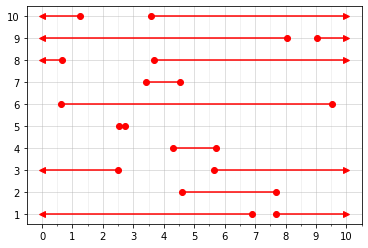

In [ ]:
# Example 3: Randomly-generated circular societies

S2 = generateRandomSociety( 'A', 10, 10, epsilon = 0.5 )
S2.printSocietyInfo()
S2.visualize(  )
a2, location2 = S2.findAgreementNumber()

print("Agreement number is: ", a2)
print("Location of max agreement along the horizontal axis (potentially one of several): ", location2)

### Example 3b: Randomly-generated circular Societies

Given a society whose approval sets are randomly generated (with a particular distribution), what is the distribution of the approval number of the random society?

In [ ]:
# Generate R random societies, each with N voters
#   Each approval set has endpts from the uniform distribution on [0, modulo]

R = 100
N = 10
modulo = 10

approval = np.empty([R,])

for i in np.arange(0, R):
  S = generateRandomSociety( 'A', N, modulo, epsilon = 0.5, mode = 2, a = 2, b=2 )
  approval[i], a = S.findAgreementNumber()

(array([24.,  0.,  0., 32.,  0.,  0., 30.,  0.,  0., 14.]),
 array([0.6 , 0.63, 0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 ]),
 <a list of 10 Patch objects>)

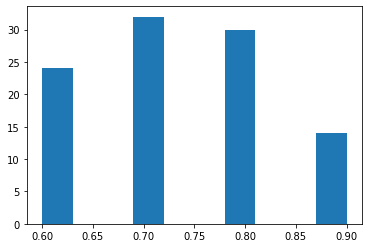

In [ ]:
approvalRatio = approval/N
plt.hist(approvalRatio, bins = 10)

In [ ]:
np.mean(approvalRatio)

0.7339999999999999

In [ ]:
S.printSocietyInfo()

Circular Society Name: A
Spectrum: [0, 10].  (Note: we identify 0 = 10)
Number of Voters: 10
Approval Sets:
 Set 1: [0,3.1373010833700157] U [7.766508866796168, 10]
 Set 2: [0,3.988072122587635] U [5.169257195787668, 10]
 Set 3: [5.585571494735917, 8.268659741399873]
 Set 4: [0,4.7259267369715] U [5.324493454378796, 10]
 Set 5: [0.6597846917064409, 2.176608933752992]
 Set 6: [2.3858432863138237, 4.991947304820513]
 Set 7: [0,0.8731749177512889] U [7.665276891494766, 10]
 Set 8: [5.07241765121842, 9.090626935684725]
 Set 9: [2.489773935442803, 6.048043878482824]
 Set 10: [3.295535251261319, 7.1333496211195975]


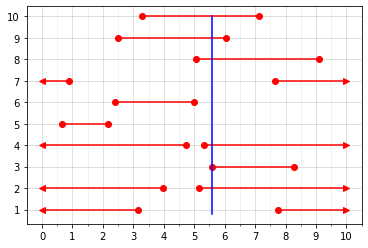

In [ ]:
S.visualize( drawAgreement = True )

In [ ]:
S.findAgreementNumber()

(6, 5.585571494735917)

### Example 4: Experiments with randomly generated fixed length societies

--------
Before any transformations
Agreement number: 2
Piercing number: 2
--------


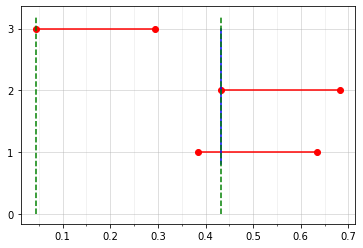

In [ ]:
# ---
# Random Example
N = 3 # number of approval sets
modulo = 1 # circumference of the circular society
p = 0.25

S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )

# ---
# Finding the agreement number of the society
a, position = S.findAgreementNumber()

print("--------")
print("Before any transformations")
print("Agreement number:", a)
p, _, _, _ = S.findPiercingNumber()
print("Piercing number:", p)
S.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

In [ ]:
S.printSocietyInfo()
tau, piercingset, _, _ = S.findPiercingNumber()
print(piercingset)

Circular Society Name: Fixed length society 1
Spectrum: [0, 1].  (Note: we identify 0 = 1)
Number of Voters: 3
Approval Sets:
 Set 1: [0.3846541495697703, 0.6346541495697703]
 Set 2: [0.43266841430606695, 0.682668414306067]
 Set 3: [0.04370607910735813, 0.29370607910735813]
[0.04370608 0.43266841]


--------
After Hardin's transformations
Agreement number after LR-alternation: 2
Piercing number after LR-alternation: 2
--------


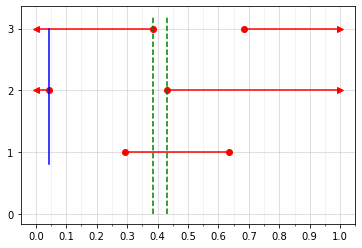

In [ ]:
# Apply transformations
Snew = copy.deepcopy(S)
Snew.uniformize()

print("--------")
print("After Hardin's transformations")
anew, _ = Snew.findAgreementNumber()
print("Agreement number after LR-alternation:", anew)
pnew, _, _, _ = Snew.findPiercingNumber()
print("Piercing number after LR-alternation:", pnew)
Snew.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

### Example 5: Checking (k, m)-agreeability

1
[]


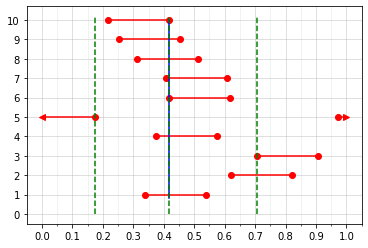

In [ ]:
# Creating a circular society S, the spectrum is [0, 1]
N = 10 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.2 # length of the society

S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S.visualize( drawAgreement = True, drawPiercing = True )

is_kmagreeable, bad_m_sets = S.checkAgreeability(4, 9)
print(is_kmagreeable)
print(bad_m_sets)

In [ ]:
is_kmagreeable, bad_m_sets = S.checkAgreeability(2, 3)
print(is_kmagreeable)
print(bad_m_sets)

0
[['Set 1', 'Set 2', 'Set 5'], ['Set 1', 'Set 3', 'Set 5'], ['Set 2', 'Set 4', 'Set 5'], ['Set 2', 'Set 5', 'Set 6'], ['Set 2', 'Set 5', 'Set 7'], ['Set 2', 'Set 5', 'Set 8'], ['Set 2', 'Set 5', 'Set 9'], ['Set 2', 'Set 5', 'Set 10'], ['Set 3', 'Set 4', 'Set 5'], ['Set 3', 'Set 5', 'Set 6'], ['Set 3', 'Set 5', 'Set 7'], ['Set 3', 'Set 5', 'Set 8'], ['Set 3', 'Set 5', 'Set 9'], ['Set 3', 'Set 5', 'Set 10']]
